In [1]:
#from mae_components import *
from mae_components_no_cls import *
import yaml
from PIL import Image
from mae_dataset import get_miniImageNetDataLoader
import torch.optim as optim
import torch
from tqdm import tqdm
import os
import torch.nn as nn
import sys
from matplotlib import pyplot as plot
from torchvision import transforms
from PIL import ImageDraw
from torchvision.transforms import functional

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [2]:
def Transpose(img):
    img=torch.clip(img,0.0,1.0)
    test_img=functional.to_pil_image(img)

    return test_img

In [3]:
def read_yaml_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = read_yaml_config('./mae_log/shift_test/config_r.yaml')
print(config)

{'Environment': {'radius': 112, 'vision_radius': 500, 'action_range': 224, 'max_steps': 15, 'grid_size': 7, 'plot_freq': 10, 'target_num': 18}, 'PrefixResnet': {'depth': 6, 'kernel_size': '([3,3],[3,3],[3,3])', 'in_channel': 3, 'requires_grad': False}, 'PrefixCNN': {'img_size': 224, 'patch_size': 16, 'in_channel': 3, 'out_channel': 512, 'requires_grad': True, 'pretrained_model_path': ''}, 'ViTEncoder': {'embed_dim': 512, 'depth': 24, 'num_heads': 16, 'mlp_ratio': 4.0, 'qkv_bias': False, 'qk_scale': False, 'drop_rate': 0.2, 'attn_drop_rate': 0.1, 'drop_path_rate': 0.1, 'num_classes': 100, 'weight_path': './mae_log/no_cls/encoder_param.pth'}, 'ViTDecoder': {'embed_dim': 256, 'depth': 8, 'num_heads': 16, 'mlp_ratio': 4.0, 'qkv_bias': False, 'qk_scale': False, 'drop_rate': 0.0, 'attn_drop_rate': 0.1, 'drop_path_rate': 0.1}, 'ShiftTransformer': {'embed_dim': 513, 'depth': 2, 'num_heads': 16, 'mlp_ratio': 4.0, 'qkv_bias': False, 'qk_scale': False, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'dr

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
mae_encoder=MaskedViTEncoder(config, 224, 16, embed_dim=512, device=device).to(device)
shift_block=ShiftTransformer(config, img_size=224, patch_size=16, embed_dim=512, device=device).to(device)
mae_decoder=MaskedViTDecoder(config, 224, 16, encoder_embed_dim=512, decoder_embed_dim=256, device=device).to(device)

In [6]:
mae_encoder.load_state_dict(torch.load("./mae_log/no_cls/encoder_param.pth"), strict=False)
shift_block.load_state_dict(torch.load("./mae_log/shift_test/shift_param_r_1.pth"), strict=False)
mae_decoder.load_state_dict(torch.load("./mae_log/no_cls/decoder_param.pth"), strict=False)
mae_encoder.eval()
shift_block.eval()
mae_decoder.eval()

MaskedViTDecoder(
  (encoder_to_decoder): Linear(in_features=512, out_features=256, bias=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
        (act2): GELU(approximate='none')
      )
    )
    (1): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): L

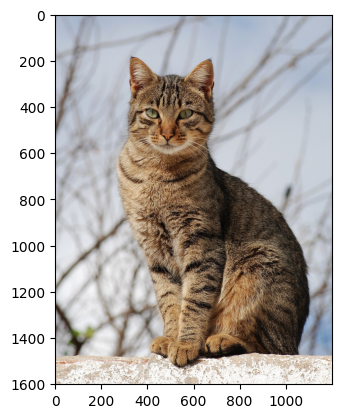

In [7]:
img=np.array(Image.open("./test_img/cat.JPEG"))
plot.imshow(img)
plot.show()

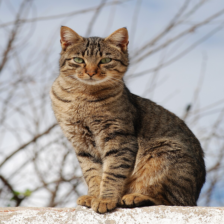

In [8]:
transform=transforms.v2.Compose([transforms.v2.ToImage(), 
                                 transforms.v2.ToDtype(torch.float32, scale=True),
                                 transforms.v2.Resize((224, 224))])
img_tensor=transform(img).unsqueeze(0).to(device)
Transpose(img_tensor[0])

[[12  1]]
(1, 196, 1)


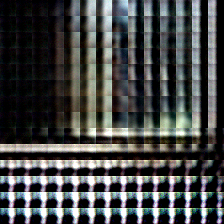

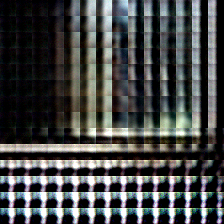

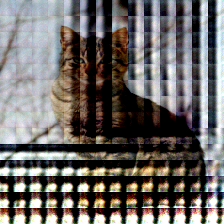

In [13]:
mask_ratio=0.0
vis=(mask_ratio==0.0)

x, mask = mae_encoder.forward_encoder(img_tensor, mask_ratio=mask_ratio)

xy = shift_block.generate_shift_cat(x)
print(xy)

shifted= shift_block.forward_encoder(x,xy)
result = mae_decoder.unpatchify(mae_decoder.forward_decoder(shifted[:, :, 1:], mask, vis=vis))
result = result[0]
img_result=Transpose(result)


display(img_result)

if not vis:
    mask=mask.squeeze()
    mask=mask.reshape(int(np.sqrt(mask.shape[0])),-1)
    print(mask.shape)


draw=ImageDraw.Draw(img_result)
img_size=224
patch_size=16

if not vis:
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            x = j*patch_size
            y = i*patch_size
            if ~mask[i][j]:
                draw.rectangle((x,y,x+patch_size,y+patch_size), fill="blue", outline="blue")

display(img_result)

residue=img_tensor[0]-result
display(Transpose(residue))

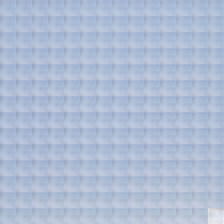

(13, 15)


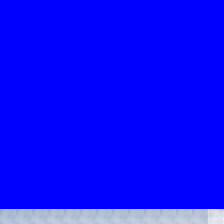

In [10]:
x, _ = mae_encoder.forward_encoder(img_tensor, mask_ratio=0.0)
fake_mask = np.zeros((x.shape[0], x.shape[1]-1), dtype=bool)

result = mae_decoder.unpatchify(mae_decoder.forward_decoder(x, fake_mask))
result = result[0]
img_result=Transpose(result)
display(img_result)

fake_mask=fake_mask.squeeze()
fake_mask=fake_mask.reshape(int(np.sqrt(fake_mask.shape[0])),-1)
print(fake_mask.shape)


draw=ImageDraw.Draw(img_result)
img_size=224
patch_size=16

for i in range(fake_mask.shape[0]):
    for j in range(fake_mask.shape[1]):
        x = j*patch_size
        y = i*patch_size
        if ~fake_mask[i][j]:
            draw.rectangle((x,y,x+patch_size,y+patch_size), fill="blue", outline="blue")

display(img_result)

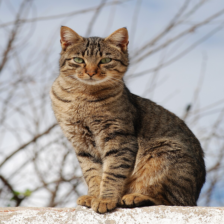

In [11]:
Transpose(mae_decoder.unpatchify(mae_decoder.patchify(img_tensor))[0])

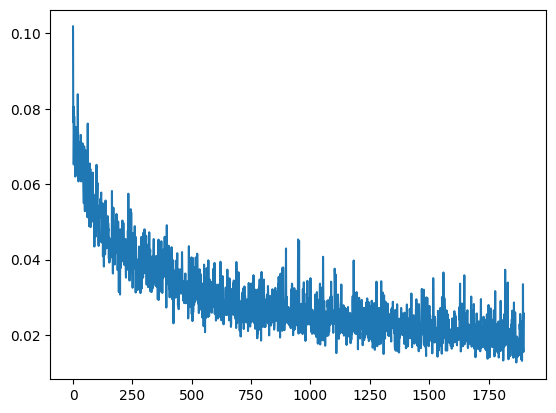

In [12]:
loss_rec=torch.load("./mae_log/shift_test/loss_r.pt")
plot.plot(loss_rec)